# Détection de fraude bancaire
### Big Data Mining M2 SISE : Pauline Lainé - Khanh Hoàng Lê

## 1. Introduction

Lorsqu'un client paye par chèque, il se peut que celui-ci ne paye jamais son panier, nous sommes alors dans le cas d'une fraude. Deux raisons peuvent être dû à une fraude. 

Le premier cas, c'est lorsque nous sommes dans le cas d'un chèque dit impayé, ce cas de figure apparait lorsque la personne ne possède pas le solde sur son compte en banque. L'autre cas de figure c'est lorsque nous avons à faire à un faux chèque. Un faux chèque peut se caractériser par une fausse identité ou lorsque le CMC7 est incorrect. Le CMC7 est une série de Caractères Magnétiques Codés à 7 bâtonnets situé en bas d'un chèque.

Sur une période de 10 mois, ces fraudes se compte au nombre de 20 000 soit 0.6% des transactions réalisées, réprésentant un chiffre d'affaires de 2 millions d'euros qui équivaut à 1.1% du chiffre d'affaires total de l'enseigne. C'est un chiffre d'affaires perdu non négligable. 

Notre étude va alors se porter sur la détection des fraudes par chèque dans un contexte déséquilibré.

## 2. Les données

Les données que nous allons utiliser provienne d'une enseigne de grande distribustion et d'organismes bancaires tels que la FNCI et la Banque de France. Nous avons une ligne par transaction sur la période du 21/03/2016 au 19/10/2016 soit une période de 7 mois. Chaque transaction est décrite par les 23 variables suivantes : 

- ZIBZIN : identifiant bancaire relatif à la personne
- IDAvisAutorisAtionCheque : identifiant de la transaction en cours
- Montant : montant de la transaction
- DateTransaction : date de la transaction
- CodeDecision : il s’agit d’une variable qui peut prendre ici 4 valeurs
    - 0 : la transaction a été acceptée par le magasin
    - 1 : la transaction et donc le client fait partie d’une liste blanche (bons payeurs). Aucun dans cette base de données
    - 2 : le client fait d’une partie d’une liste noire, son historique indique c'est un mauvais payeur (des impayés en cours ou des incidents bancaires en cours), sa transaction est alors automatiquement refusée
    - 3 : client ayant était arrêté par le système par le passé pour une raison plus ou moins fondée
- VérifianceCPT1 : nombre de transactions effectuées par le même identifiant bancaire au cours du même jour
- VérifianceCPT2 : nombre de transactions effectuées par le même identifiant bancaire au cours des trois derniers jours
- VérifianceCPT3 : nombre de transactions effectuées par le même identifiant bancaire au cours des sept derniers jours
- D2CB : durée de connaissance du client (par son identifiant bancaire), en jours. Pour des contraintes légales, cette durée de connaissance ne peut excéder deux ans
- ScoringFP1 : score d’anormalité du panier relatif à une première famille de produits (ex : denrées alimentaires)
- ScoringFP2 : score d’anormalité du panier relatif à une deuxième famille de produits(ex : électroniques)
- ScoringFP3 : score d’anormalité du panier relatif à une troisième famille de produits (ex : autres)
- TauxImpNb_RB : taux impayés enregistrés selon la région où a lieu la transaction
- TauxImpNB_CPM : taux d’impayés relatif au magasin où a lieu la transaction
- EcartNumCheq : différence entre les numéros de chèques
- NbrMagasin3J : nombre de magasins différents fréquentés les 3 derniers jours
- DiffDateTr1 : écart (en jours) à la précédente transaction
- DiffDateTr2 : écart (en jours) à l’avant dernière transaction
- DiffDateTr3 : écart (en jours) à l’antépénultième transaction
-  CA3TRetMtt : montant des dernières transactions + montant de la transaction en cours
- CA3TR : montant des trois dernières transactions
- Heure : heure de la transaction
- FlagImpaye : acception (0) ou refus de la transaction (1)

Cette dernière variable "FlagImpaye" est celle que nous cherchons à prédire. La classe 0 correspondant aux transactions normales et acceptées et la classe 1 correspond aux fraudes, les transactions qui sont refusées.

Voyons à présent de plus près à quoi ressemble nos données.

### Importation des librairies 

In [1]:
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import imblearn
print(imblearn.__version__)

ModuleNotFoundError: No module named 'imblearn'

### Importation du jeu de données 

In [5]:
import os
os.chdir("D:/OneDrive/Documents/COURS/M2 SISE/Big Data Mining/Projet")
df = pd.read_csv("dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')
#df =pd.read_csv("/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')

In [16]:
df.head()

,ZIBZIN,IDAvisAutorisAtionCheque,MontAnt,DAteTrAnsAction,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
0,A034010041908012010710730,71051532,40.17,2016-03-21 07:47:38,0,1,1,1,535,0.0,...,21.834061,0,1,4.0,4.0,4.0,40.17,0.0,28058,0
1,A035010041908006493331734,71051533,20.00,2016-03-21 08:04:57,0,0,0,0,358,0.0,...,12.586532,0,1,4.0,4.0,4.0,20.00,0.0,29097,0
2,A013010003908005150136747,71051534,35.00,2016-03-21 08:06:45,0,0,0,0,199,0.0,...,39.274924,0,1,4.0,4.0,4.0,35.00,0.0,29205,0
3,A013010041908025639221029,71051536,20.00,2016-03-21 08:11:38,0,0,0,0,38,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29498,0
4,A013010003908005556100283,71051538,20.00,2016-03-21 08:17:11,0,0,0,0,26,0.0,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29831,0


In [19]:
print(np.shape(df))
print(df.info())

(2231369, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisAtionCheque  int64  
 2   MontAnt                   float64
 3   DAteTrAnsAction           object 
 4   CodeDecision              int64  
 5   VerifiAnceCPT1            int64  
 6   VerifiAnceCPT2            int64  
 7   VerifiAnceCPT3            int64  
 8   D2CB                      int64  
 9   ScoringFP1                float64
 10  ScoringFP2                float64
 11  ScoringFP3                float64
 12  TAuxImpNb_RB              float64
 13  TAuxImpNB_CPM             float64
 14  EcArtNumCheq              int64  
 15  NbrMAgAsin3J              int64  
 16  DiffDAteTr1               float64
 17  DiffDAteTr2               float64
 18  DiffDAteTr3               float64
 19  CA3TRetMtt                float64
 20  CA3TR     

Nous avons une base de données de plus de 2 millions de transactions (2 231 369) caractérisé par 23 variables. La plus part sont quantitative de type "int64" et "float64". Deux variables sont de type qualitative : "ZIBZIN" qui correspond a l'indentifiant de la personne et la variable "DAteTrAnsAction" qui correspond à la date de la transaction.

In [21]:
df.describe()

,IDAvisAutorisAtionCheque,MontAnt,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
count,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,...,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06
mean,7.356762e+07,5.991771e+01,1.288043e-02,3.991402e-01,4.296752e-01,4.816980e-01,2.477938e+02,3.100542e+00,6.882686e-01,1.769416e-01,...,3.256122e+01,6.724334e+03,1.034200e+00,3.947808e+00,4.234163e+00,4.266234e+00,6.683475e+01,6.917041e+00,5.347306e+04,2.804108e-03
std,1.458268e+06,7.980922e+01,1.682062e-01,5.250070e-01,6.056457e-01,7.339127e-01,2.131088e+02,3.047480e+01,9.336748e+00,5.662696e-01,...,3.475789e+01,1.742520e+05,1.862585e-01,1.078915e+00,5.510923e-01,4.643674e-01,8.929606e+01,3.550385e+01,1.200173e+04,5.287955e-02
min,7.105153e+07,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.969986e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.745370e-04,1.365741e-03,1.000000e-02,0.000000e+00,1.336000e+03,0.000000e+00
25%,7.232987e+07,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.874265e-03,-2.869431e+00,1.179973e-03,...,1.390821e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.792000e+01,0.000000e+00,4.248500e+04,0.000000e+00
50%,7.353719e+07,4.235000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.430000e+02,1.543502e-02,0.000000e+00,2.131271e-03,...,2.526529e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.732000e+01,0.000000e+00,5.488200e+04,0.000000e+00
75%,7.480167e+07,7.205000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.680000e+02,1.370299e-01,5.289664e+00,1.533859e-02,...,3.927492e+01,0.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,8.130000e+01,0.000000e+00,6.390700e+04,0.000000e+00
max,7.619241e+07,1.698534e+04,3.000000e+00,1.500000e+01,4.000000e+01,4.000000e+01,5.510000e+02,1.680000e+04,4.702998e+01,1.839140e+01,...,7.142857e+02,9.993474e+06,1.000000e+01,5.000000e+00,5.000000e+00,5.000000e+00,1.698534e+04,1.060000e+04,8.256400e+04,1.000000e+00


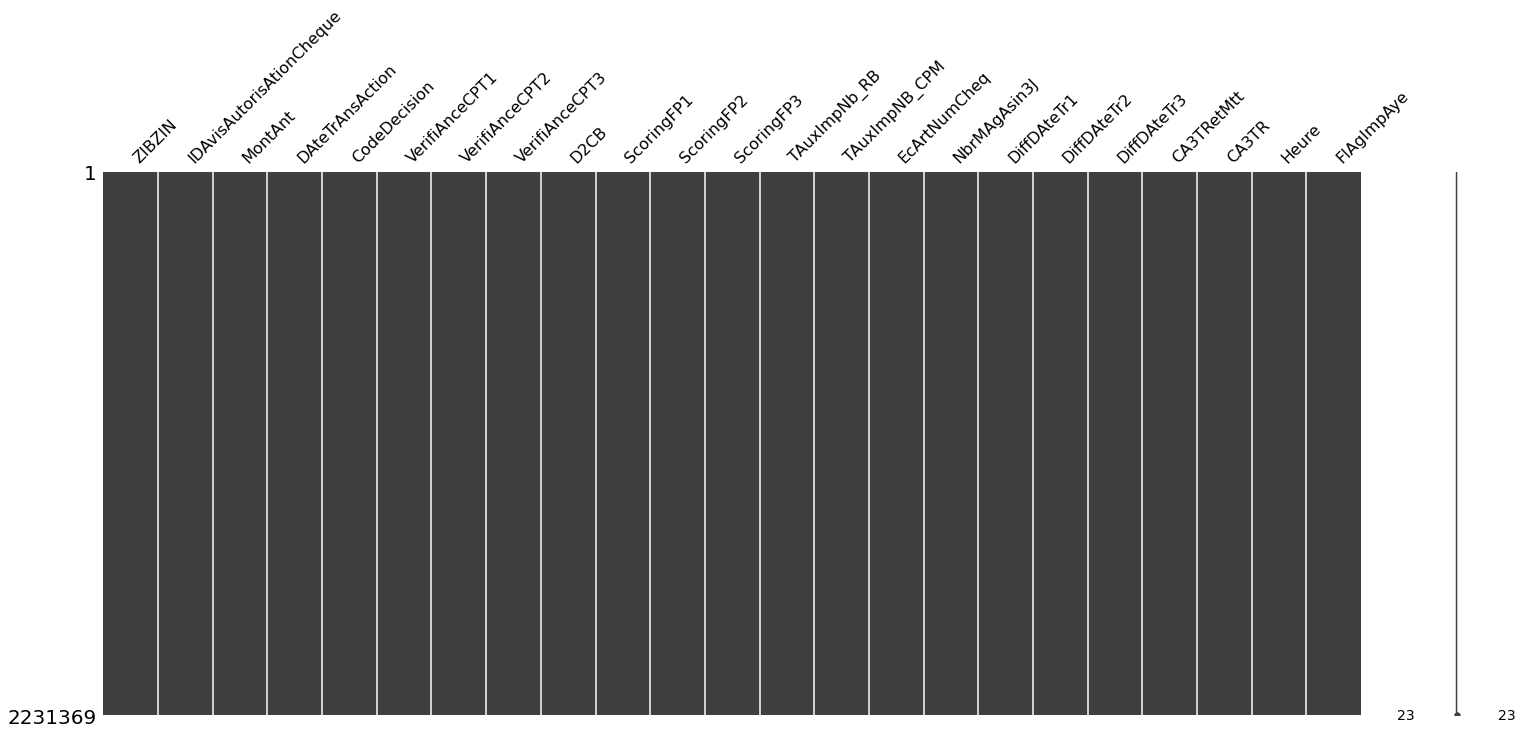

In [22]:
# Null Values
mn.matrix(df)

In [12]:
null_df_perc = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
null_df_perc.columns = ['Column Name', 'Null Values Percentage']
null_df_value = pd.DataFrame(df.isnull().sum()).reset_index()
null_df_value.columns = ['Column Name', 'Null Values']
null_df = pd.merge(null_df_value, null_df_perc, on='Column Name')
null_df.sort_values(by='Null Values Percentage', ascending=False)

,Column Name,Null Values,Null Values Percentage
0,ZIBZIN,0,0.0
12,TAuxImpNb_RB,0,0.0
21,Heure,0,0.0
20,CA3TR,0,0.0
19,CA3TRetMtt,0,0.0
18,DiffDAteTr3,0,0.0
17,DiffDAteTr2,0,0.0
16,DiffDAteTr1,0,0.0
15,NbrMAgAsin3J,0,0.0
14,EcArtNumCheq,0,0.0


In [14]:
print(df.isnull().sum())

ZIBZIN                      0
IDAvisAutorisAtionCheque    0
MontAnt                     0
DAteTrAnsAction             0
CodeDecision                0
VerifiAnceCPT1              0
VerifiAnceCPT2              0
VerifiAnceCPT3              0
D2CB                        0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TAuxImpNb_RB                0
TAuxImpNB_CPM               0
EcArtNumCheq                0
NbrMAgAsin3J                0
DiffDAteTr1                 0
DiffDAteTr2                 0
DiffDAteTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
FlAgImpAye                  0
dtype: int64


Il y a 0 null values 

# Analyse univarié

In [6]:
pd.value_counts(df['FlAgImpAye'])

0    2225112
1       6257
Name: FlAgImpAye, dtype: int64

On peut voir que la classe "frauduleuse" est extremement petite par rapport que la classe normale. En fait, dans ce cas la, oversampling sera mieux comme on ne veut pas perdre les infos importants sur les classes

## Extraire Mois pour Train et Test

Le but est de creer train et test chrono, pas en aléatoire donc nous allons observer la repartition de mois

In [83]:
df['DAteTrAnsAction'] = pd.to_datetime(df['DAteTrAnsAction'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 24 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ZIBZIN                    object        
 1   IDAvisAutorisAtionCheque  int64         
 2   MontAnt                   float64       
 3   DAteTrAnsAction           datetime64[ns]
 4   CodeDecision              int64         
 5   VerifiAnceCPT1            int64         
 6   VerifiAnceCPT2            int64         
 7   VerifiAnceCPT3            int64         
 8   D2CB                      int64         
 9   ScoringFP1                float64       
 10  ScoringFP2                float64       
 11  ScoringFP3                float64       
 12  TAuxImpNb_RB              float64       
 13  TAuxImpNB_CPM             float64       
 14  EcArtNumCheq              int64         
 15  NbrMAgAsin3J              int64         
 16  DiffDAteTr1               float64       
 17  DiffDAte

In [75]:
df['Month']=df['DAteTrAnsAction'].dt.month
a=pd.value_counts(df['Month'])
print(df['Month'].unique())

[ 3  4  5  6  7  8  9 10]


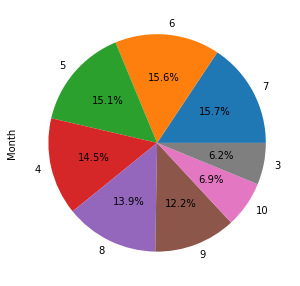

In [76]:
plot = a.plot.pie(y='Month', figsize=(5, 5),autopct='%1.1f%%')

Donc nous avons 8 mois en total,le premier et le dernier et celui qui a le moins activité.

# Train et Test

In [131]:
Apprenti = df.loc[df['DAteTrAnsAction'] < '2016-09-20'] 
Test = df.loc[df['DAteTrAnsAction'] >= '2016-09-20'] 
print(Apprenti['DAteTrAnsAction'].unique())
print(Test['DAteTrAnsAction'].unique())

['2016-03-21T07:47:38.000000000' '2016-03-21T08:04:57.000000000'
 '2016-03-21T08:06:45.000000000' ... '2016-09-19T21:15:19.000000000'
 '2016-09-19T21:43:41.000000000' '2016-09-19T21:51:09.000000000']
['2016-09-20T07:33:50.000000000' '2016-09-20T08:05:18.000000000'
 '2016-09-20T08:06:20.000000000' ... '2016-10-19T21:29:04.000000000'
 '2016-10-19T21:46:26.000000000' '2016-10-19T21:57:52.000000000']


On va créer les variables en supprimant les valeurs ID + Date + Heure qui ne nous concernce pas vraiment

In [147]:
training_features= Apprenti.drop(Apprenti.columns[[0, 1,3,21,22,23]], axis=1) 
training_target = Apprenti['FlAgImpAye']
#print(X_train.shape)
print(training_features.info())
print(training_target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967226 entries, 0 to 1967225
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   MontAnt         float64
 1   CodeDecision    int64  
 2   VerifiAnceCPT1  int64  
 3   VerifiAnceCPT2  int64  
 4   VerifiAnceCPT3  int64  
 5   D2CB            int64  
 6   ScoringFP1      float64
 7   ScoringFP2      float64
 8   ScoringFP3      float64
 9   TAuxImpNb_RB    float64
 10  TAuxImpNB_CPM   float64
 11  EcArtNumCheq    int64  
 12  NbrMAgAsin3J    int64  
 13  DiffDAteTr1     float64
 14  DiffDAteTr2     float64
 15  DiffDAteTr3     float64
 16  CA3TRetMtt      float64
 17  CA3TR           float64
dtypes: float64(11), int64(7)
memory usage: 285.2 MB
None
0          0
1          0
2          0
3          0
4          0
          ..
1967221    0
1967222    0
1967223    0
1967224    0
1967225    1
Name: FlAgImpAye, Length: 1967226, dtype: int64


Donc on va définir l'ensemble d'entrainement, de validation et test.

In [148]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.3,
                                                  shuffle=False 
                                                  )

In [149]:
test_features= Test.drop(Apprenti.columns[[0, 1, 3,21,22,23]], axis=1) 
test_target = Test['FlAgImpAye']

Test ( en commentaire )

In [24]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

TypeError: '(slice(None, None, None), slice(None, 2, None))' is an invalid key

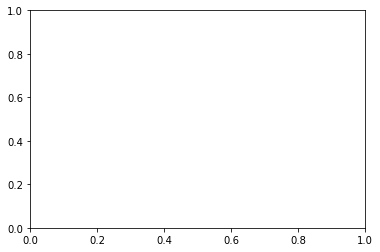

In [25]:
ax = plt.gca()
plot_decision_function(X[:, :2][:1000], y[:1000], LinearSVC().fit(X[:, :2][:5000], y[:5000]), ax)

# SMOTE OverSamplingwith Random Forest

In [26]:
#training_features, test_features, \
#training_target, test_target, = train_test_split(df.drop(df.columns[[0, 1, 3,21,22]], axis=1),
                                               #df['FlAgImpAye'],
                                               #test_size = .1,
                                               #random_state=12)

In [27]:
#x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  #test_size = .1,
                                                 # random_state=12)

In [150]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)


In [117]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=25, random_state=12))
#clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
#clf_rf.fit(x_train_res, y_train_res)
pipe.fit(x_train_res, y_train_res) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, random_state=12))])

In [37]:
print ('Validation Results')
print (clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print (f1_score(y_val, clf_rf.predict(x_val)))
print ('\nTest Results')
print (clf_rf.score(test_features, test_target))
print (recall_score(test_target, clf_rf.predict(test_features)))
print (f1_score(test_target, clf_rf.predict(test_features)))

Validation Results
0.9935366290881568
0.1099290780141844
0.08720112517580873

Test Results
0.9933807481502396
0.10725552050473186
0.08431494110353377


# Exporter and save 

In [102]:
  %notebook '/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'

FileNotFoundError: [Errno 2] No such file or directory: "'/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'"